In [58]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [59]:
def cluster_variance(n, x):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
    return variances,K,n

In [68]:
ds = xr.open_dataset(f"challenge_1min_numerical.nc")

ds = ds.where((ds.latitude > 0) & (ds.latitude < 20) & (ds.longitude > 100) & (ds.longitude < 160), drop=True)


sh: 1: getfattr: not found


In [70]:
x = ds.drop_vars(['latitude','longitude']).to_array().transpose("time", "variable").values
# x = ds.to_array().transpose("time", "variable").values

x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
x

array([[5.30952381e-01, 2.46442596e-01, 1.95182172e-01, 0.00000000e+00],
       [1.00000000e+00, 2.91593423e-01, 6.93596711e-01, 0.00000000e+00],
       [3.54761905e-01, 4.17597047e-01, 2.08013494e-01, 0.00000000e+00],
       ...,
       [9.04761905e-02, 4.15673034e-03, 1.15608714e-02, 2.11663499e-02],
       [0.00000000e+00, 2.48892251e-01, 1.18477158e-02, 2.02430779e-02],
       [0.00000000e+00, 5.36243434e-04, 1.11159636e-02, 0.00000000e+00]],
      shape=(1073, 4))

Initialization complete
Iteration 0, inertia 112.85924299434916.
Iteration 1, inertia 82.47404380603507.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 82.69712221783506.
Iteration 1, inertia 60.35392313267058.
Iteration 2, inertia 56.37640949258556.
Iteration 3, inertia 55.41183836582003.
Iteration 4, inertia 54.62362387152908.
Iteration 5, inertia 53.573707051726025.
Iteration 6, inertia 50.643927061708865.
Iteration 7, inertia 48.217052842670405.
Iteration 8, inertia 47.760237146927764.
Iteration 9, inertia 47.69493616849621.
Iteration 10, inertia 47.66972506248009.
Iteration 11, inertia 47.66015144060461.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 50.42788615756061.
Iteration 1, inertia 33.03843580558973.
Iteration 2, inertia 32.8956402100156.
Iteration 3, inertia 32.88063205510431.
Iteration 4, inertia 32.8749881994381.
Iteration 5, inertia 32.87413682598882.
Converged at iteration 5: stri

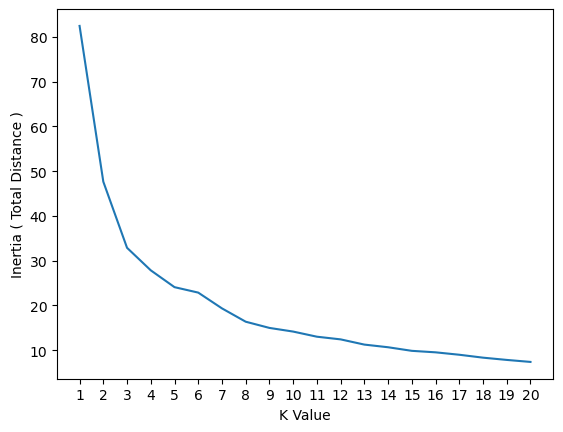

In [71]:
variances,K,n=cluster_variance(20, x)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

In [72]:
ds

<xarray.Dataset> Size: 47kB
Dimensions:                          (time: 1073)
Coordinates:
  * time                             (time) datetime64[ns] 9kB 2025-06-12T06:...
Data variables:
    latitude                         (time) float64 9kB 16.59 12.7 ... 17.28
    longitude                        (time) float64 9kB 107.4 106.7 ... 116.8
    land_flag                        (time) float64 9kB 0.531 1.0 ... 0.0 0.0
    ice_water_path                   (time) float32 4kB 0.5041 ... 0.001097
    liquid_water_path                (time) float32 4kB 0.1489 ... 0.008478
    aerosol_optical_thickness_355nm  (time) float32 4kB 0.0 0.0 ... 0.06878 0.0

In [113]:
k = 5

# Applichiamo K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(x)


In [81]:
vars = {
    # 'lat': 0,
    # 'lon': 1,
    'landf' : 0 ,
    'iwp': 1,
    'lwp': 2,
    'aot': 3
}

In [181]:
def plot_kmeans(x, varX, varY, ax=None):

    if not ax:
        fig, ax = plt.subplots()
    
    # Visualizziamo i dati colorati in base ai cluster trovati
    ax.scatter(x[:, vars[varX]], x[:, vars[varY]], c=y_kmeans, s=10, cmap='jet', alpha=0.5)  #'viridis')
    
    # Mostriamo anche i centroidi
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, vars[varX]], centers[:,  vars[varY]], c='red', s=50, alpha=0.75, marker='X', label='Centroids')
    for i in np.arange(1,6):
        ax.text(centers[(i-1), vars[varX]]*1.1, centers[(i-1),  vars[varY]]*1.1, s=str(i), c='red')
    
    ax.set_title("K-Means clustering")
    ax.set_xlabel(varX)
    ax.set_ylabel(varY)
    ax.legend()


In [182]:
[str(i) for i in np.arange(1,6)]

['1', '2', '3', '4', '5']

In [183]:
kmeans.cluster_centers_

array([[0.00448645, 0.02347211, 0.03839634, 0.02480364],
       [0.85919913, 0.150738  , 0.29996317, 0.06417443],
       [0.01778388, 0.36370456, 0.17443704, 0.01821864],
       [0.00609756, 0.04188931, 0.12614038, 0.22670157],
       [0.33928571, 0.08486468, 0.19159653, 0.03006835]])

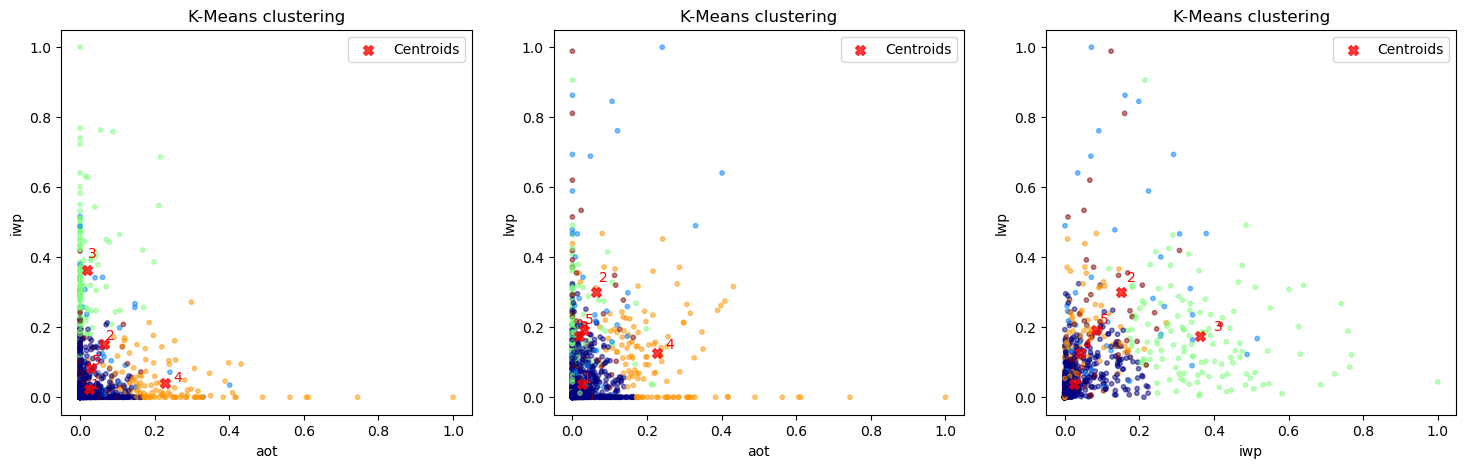

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY, ax=axes[0])

varX='aot'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[1])


varX='iwp'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[2])

(0.0, 0.25)

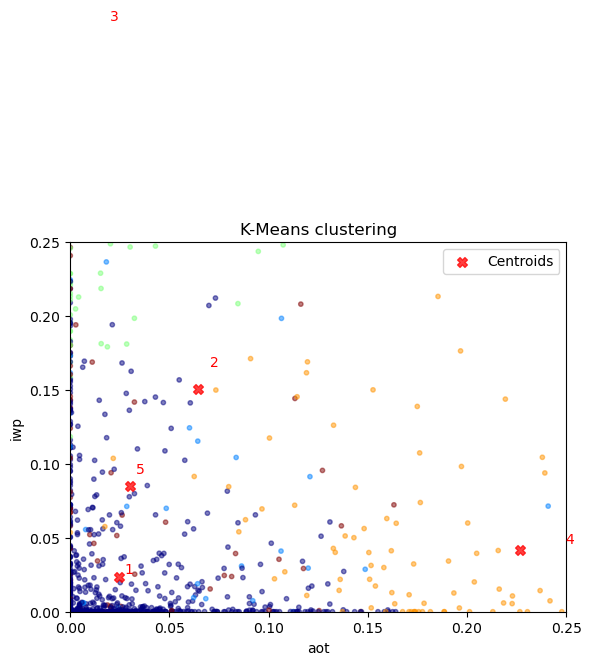

In [185]:
varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY)
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

### Classes we were expepcting:

- Cluster 4: Aerosol with no clouds

- Cluster 3: Ice and water with no transparency (ATLID is not seeing aerosol)

Let's see the other three


In [ ]:
# select only clusters 1, 2 and 5

In [247]:
np.unique(y_kmeans)

array([0, 1, 2, 3, 4], dtype=int32)

In [244]:
indices = np.where((y_kmeans == 0) | (y_kmeans == 1) | (y_kmeans == 4))[0]

In [219]:
(vars['iwp'], vars['aot'])

(1, 3)

In [239]:
a = x[indices, 3]
b = x[indices, 1]

m, q = np.polyfit(a, b, deg=1)

b_pred = q + m * a #+ n *a**2

print(q, m, n)


0.03771770565867679 -0.10801429520186795 0.7336520872353375


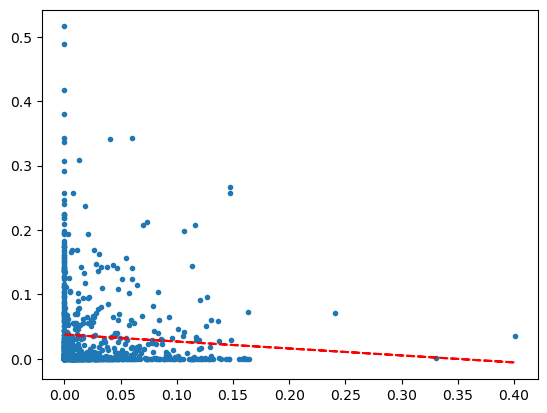

In [243]:
varX='aot'
varY='iwp'

# plot_kmeans(x, varX, varY)
# plt.xlim(0, 0.25)
# plt.ylim(0, 0.25)

plt.plot(a, b, '.')
plt.plot(a, b_pred, 'r--')

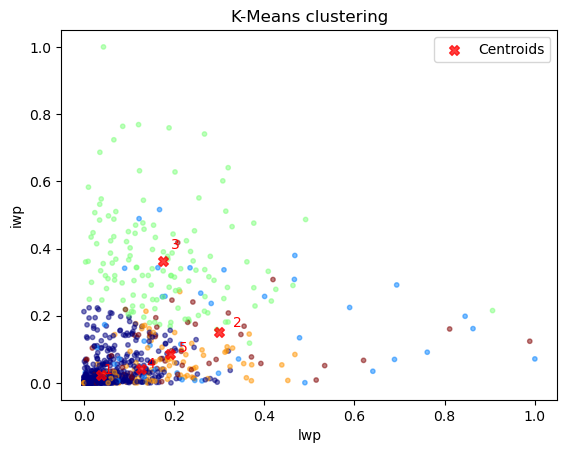

In [241]:
varX='lwp'
varY='iwp'

plot_kmeans(x, varX, varY)

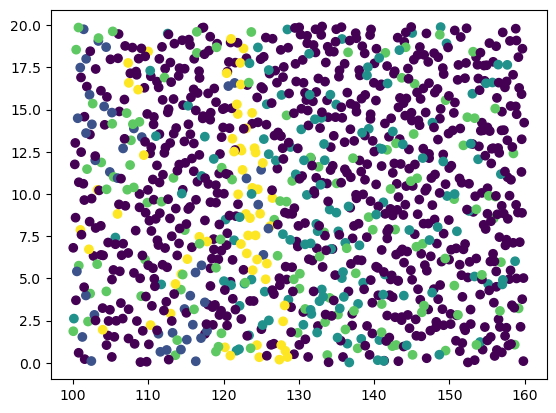

In [191]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='viridis')

Text(0, 0.5, 'latitude')

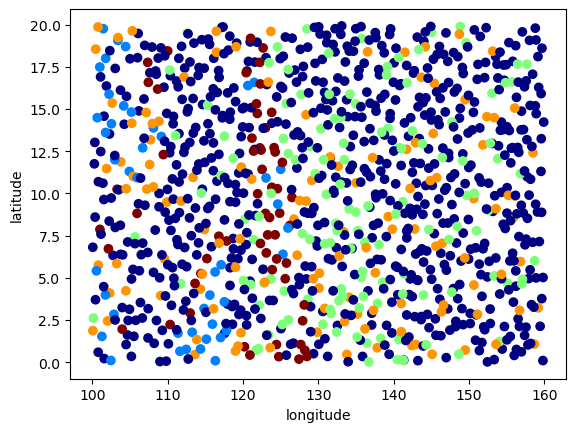

In [195]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='jet')
plt.xlabel('longitude')
plt.ylabel('latitude')